<h1 style="text-align:center">Deep Learning   </h1>
<h1 style="text-align:center"> Lab Session 3 - 1.5 Hours </h1>
<h1 style="text-align:center"> Sentiment Analysis with Recurrent Neural Networks</h1>

<b> Group name:</b> # DeepLearn25
 
 
The aim of this session is to practice with VanillaRNN and Gated Recurrent Units (GRU). Each group should fill and run appropriate notebook cells. 


Generate your final report in HTML and upload it (along with any necessary images files using a zip archive) on the submission website http://bigfoot-m1.eurecom.fr/teachingsub/login (using your deeplearnXX/password). Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed and submitted by June 15th 2018 (23:59:59 CET).

# Section 1: Sentiment Analysis with a Vanilla RNN

In this part, you have no code to write. However you should spend some time stydying the code provided, to fully understand how the Vanilla RNN is implemented: you will implement a GRU in a similar way in Section 2.

You will work on a corpus of 3,000 user comments taken from IMDb (1,000), Amazon (1,000) and Yelp (1,000). These comments are split into two categories: positive comments (denoted by "1") and negative comments (denoted by "0"). For each website, 500 comments are positive and 500 comments are negative. This corpus has been created for the paper <i>From Group to Individual Labels using Deep Features</i> by Kotzias <i>et al</i> (KDD '15 Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, Pages 597-606, Sydney, NSW, Australia — August 10 - 13, 2015, ACM New York, NY, USA ©2015  ISBN: 978-1-4503-3664-2 doi>10.1145/2783258.2783380).

In this lab, we split this dataset into a training set of 2,520 comments (420 positive comments and 420 negative comments from each website), a validation set of 240 comments (40 positive comments and 40 negative comments from each website) and a test set of 240 comments (40 positive comments and 40 negative comments from each website).

Your goal will be to classify automatically these sentences by training a Vanilla RNN and then a GRU. Please note that we use the word2vec method to convert words into vectors (Embedding of 300 dimensions in this lab): these vectors are designed so that they reflect the semantic and the syntactic functions of words. You can read more about word2vec in the paper <i>Distributed representations of words and phrases and their compositionality</i> by Mikolov <i>et al.</i> (NIPS'13 Proceedings of the 26th International Conference on Neural Information Processing Systems - Volume 2, Pages 3111-3119, Lake Tahoe, Nevada — December 05 - 10, 2013).

First of all, please run the following cell.

In [1]:
# Imports
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
import numpy as np
import utils

# Parameters
epsilon = 1e-10
max_l = 32 # Max length of sentences

train, val, test, word2vec = utils.load_data()
data = utils.Dataset(train, val, test, word2vec)

In the following cell, we define a VanillaRNN class. Please read its code carefully before running the cell because you will need to implement a similar class for the GRU.

If our sentence is represented by the sequence $(x_1, ..., x_L)$, the hidden states $h_t$ of the Vanilla RNN are defined as

<div align="center">$h_0 = 0$</div>
<div align="center">$h_{t+1} = f(W_h h_t + W_x x_{t+1} + b)$</div>

where $W_h$, $W_x$ and $b$ are trainable parameters and $f$ is an activation function.

In [2]:
class VanillaRNN:

    def __init__(self, input_size, hidden_states, activation=None, name=None):
        self._hidden_states = hidden_states
        self._input_size = input_size
        self._activation = activation or tf.tanh
        self._name = (name or "vanilla_rnn") + "/"
        self._candidate_kernel = tf.get_variable(self._name + "candidate/weights",
                                                   shape=[input_size + self._hidden_states, self._hidden_states])
        self._candidate_bias = tf.get_variable(self._name + "candidate/bias", shape=[self._hidden_states])

    def state_size(self):
        return self._hidden_states

    def zero_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros([batch_size, self.state_size()], dtype=tf.float32)

    def __call__(self, inputs, state):

        candidate = tf.concat([inputs, state], 1) @ self._candidate_kernel
        candidate = tf.nn.bias_add(candidate, self._candidate_bias)
        new_h = self._activation(candidate)
        return new_h

<b>Parameters</b>
* Learning rate: 0.001
* Training epochs: 30
* Batch size: 128
* Hidden states: 50

In [3]:
# Parameters
learning_rate = 0.001
training_epochs = 30
batch_size = 128
hidden_states = 50

Then we define our model. Please read the code of the process_sequence() function to understand the utility of the MaskData placeholder. If $h_L$ is the last hidden state of the Vanilla RNN, then we define our final prediction $p$ as

<div align="center">$p = \sigma (W_{pred} h_L + b_{pred})$</div>

where $W_{pred}$ and $b_{pred}$ are trainable parameters and $\sigma$ denotes the sigmoid function.

In [4]:
tf.reset_default_graph()
tf.set_random_seed(123)
model_path = "models/vanilla.ckpt"
# tf Graph Input:  sentiment analysis data
# Sentences are padded with zero vectors
x = tf.placeholder(tf.float32, [None, max_l, 300], name='InputData')
# masks: necessary as we have different sentence lengths
m = tf.placeholder(tf.float32, [None, max_l, 1], name='MaskData')
# positive (1) or negative (0) labels
y = tf.placeholder(tf.float32, [None, 1], name='LabelData')

# we define our VanillaRNN cell
vanilla = VanillaRNN(300, hidden_states)

# we retrieve its last output
vanilla_output = utils.process_sequence(vanilla, x, m)

W = tf.Variable(tf.zeros([hidden_states, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
# we make the final prediction
pred = tf.nn.sigmoid(vanilla_output @ W + b)

Eventually, we train our model using a cross-entropy loss and the Adam optimizer. At each epoch we check the validation accuracy, and save the model if that accuracy increased. At the end, we load the best model on validation, and print its accuracy on the test set.

We test our model using a $\tanh$ activation function.

In [5]:
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    cost = tf.reduce_mean(
        -y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)) 
        - 
        (1.-y)*tf.log(tf.clip_by_value((1.-pred), epsilon, 1.0))
    )

with tf.name_scope('Adam'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    pred_tmp = tf.stack([pred, 1.-pred])
    y_tmp = tf.stack([y, 1.-y])
    acc = tf.equal(tf.argmax(pred_tmp, 0), tf.argmax(y_tmp, 0))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    print("Training started")
    best_val_acc = 0.
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ms, batch_ys = data.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c = sess.run([optimizer, cost],
                                     feed_dict={x: batch_xs, y: batch_ys, m: batch_ms})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        val_xs, val_ms, val_ys = data.val_batch()
        val_acc = acc.eval({x: val_xs, m: val_ms, y: val_ys})
        print("\nEpoch: {:02d}\tLoss:\t\t\t{:.9f}".format(epoch+1, avg_cost))
        print("\t\tAccuracy on validation:\t{:.9f}".format(val_acc))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = saver.save(sess, model_path)
            print("\t\tModel saved in file:\t{}".format(save_path))
        

    # Test model
    # Calculate accuracy
    saver.restore(sess, model_path)
    test_xs, test_ms, test_ys = data.test_batch()
    print("\nFinal accuracy:", acc.eval({x: test_xs, m: test_ms, y: test_ys}))

Training started

Epoch: 01	Loss:			0.694689286
		Accuracy on validation:	0.500000000
		Model saved in file:	models/vanilla.ckpt

Epoch: 02	Loss:			0.690510929
		Accuracy on validation:	0.666666687
		Model saved in file:	models/vanilla.ckpt

Epoch: 03	Loss:			0.662441818
		Accuracy on validation:	0.741666675
		Model saved in file:	models/vanilla.ckpt

Epoch: 04	Loss:			0.582807055
		Accuracy on validation:	0.691666663

Epoch: 05	Loss:			0.528966646
		Accuracy on validation:	0.779166639
		Model saved in file:	models/vanilla.ckpt

Epoch: 06	Loss:			0.471235694
		Accuracy on validation:	0.795833349
		Model saved in file:	models/vanilla.ckpt

Epoch: 07	Loss:			0.430951139
		Accuracy on validation:	0.800000012
		Model saved in file:	models/vanilla.ckpt

Epoch: 08	Loss:			0.417721425
		Accuracy on validation:	0.820833325
		Model saved in file:	models/vanilla.ckpt

Epoch: 09	Loss:			0.395720712
		Accuracy on validation:	0.820833325

Epoch: 10	Loss:			0.373930128
		Accuracy on validation:	0.82

Did you understand everything? If so, you can move towards Section 2.

# Section 2: Your turn!

<b>Question 1</b> - Recall the formulas defining the hidden states of a GRU.

Here is the principle of a GRU cell:

![]( 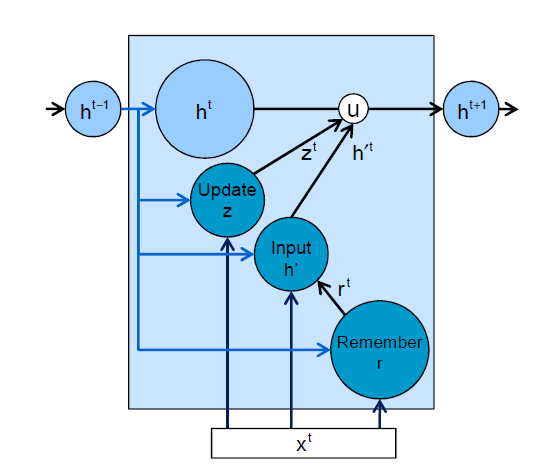)

The GRU is composed of gates within the compute cell without a dedicated memory cell. The Gates formulas are as follows:

* Remember Gate: 
  * $r^t=sigmoid\left(W_r\cdot[h^{t-1}, x^t]+b_r\right)$
* Input Gate:
  * $h'^t=tanh\left(W_i\cdot[r^t\otimes h^{t-1},x^t]+b_i\right)$
* Update Gate: 
  * $z^t = sigmoid\left(W_z\cdot [h^{t-1},x^t]+b_z\right)$
  * $h^{t+1} = z^t \otimes h'^t + (1-z^t) \otimes h^t$
  
Note that the $tanh$ function is here the activation function, and the $sigmoid$ functions on the gates are meant to act as a switch (value of 0 or 1) but they have to be differentiable, thus the sigmoid function is choosen.

<b>Question 2</b> - Define a GRU similar to the Vanilla RNN that we defined in Section 1.

In [6]:
class GRU:

    def __init__(self, input_size, hidden_states, activation=None, name=None):
        self._hidden_states = hidden_states
        self._input_size = input_size
        self._activation = activation or tf.tanh
        self._name = (name or "gru") + "/"

        # Remember GATE
        self._candidate_remember_kernel = tf.get_variable(
            self._name + "candidate/remember/weights",
            shape=[input_size + self._hidden_states, self._hidden_states]
        )
        self._candidate_remember_bias = tf.get_variable(
            self._name + "candidate/remember/bias", 
            shape=[self._hidden_states]
        )
        # Input GATE
        self._candidate_input_kernel = tf.get_variable(
            self._name + "candidate/input/weights",
            shape=[input_size + self._hidden_states, self._hidden_states]
        )
        self._candidate_input_bias = tf.get_variable(
            self._name + "candidate/input/bias", 
            shape=[self._hidden_states]
        )
        # Update GATE
        self._candidate_update_kernel = tf.get_variable(
            self._name + "candidate/update/weights",
            shape=[input_size + self._hidden_states, self._hidden_states]
        )
        self._candidate_update_bias = tf.get_variable(
            self._name + "candidate/update/bias", 
            shape=[self._hidden_states]
        )

    def state_size(self):
        return self._hidden_states

    def output_size(self):
        return self._hidden_states

    def zero_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros([batch_size, self.state_size()], dtype=tf.float32)

    def __call__(self, inputs, state):
        rt = tf.sigmoid(
            tf.concat([inputs, state], 1)
            @
            self._candidate_remember_kernel 
            +
            self._candidate_remember_bias
        )
        
        hpt = tf.tanh(
            tf.concat([inputs, rt * state], 1)
            @
            self._candidate_input_kernel 
            +
            self._candidate_input_bias
        )
        
        zt = tf.sigmoid(
            tf.concat([inputs, state], 1)
            @
            self._candidate_update_kernel 
            +
            self._candidate_update_bias
        )
        
        new_h = zt * hpt + (1-zt)*state
        return new_h


<b>Question 3</b> - Train that GRU with a $tanh$ activation function and print its accuracy on the test set.

In [7]:
import os 
# Create the summary path is not existing
if not os.path.exists('summaries'):
    os.mkdir('summaries')
if not os.path.exists(os.path.join('summaries','first')):
    os.mkdir(os.path.join('summaries','first'))
tf.reset_default_graph()

In [8]:
tf.set_random_seed(123)
model_path = "models/gru.ckpt"
# tf Graph Input:  sentiment analysis data
x = tf.placeholder(tf.float32, [None, max_l, 300], name='InputData')
# masks
m = tf.placeholder(tf.float32, [None, max_l, 1], name='MaskData')
# Positive (1) or Negative (0) labels
y = tf.placeholder(tf.float32, [None, 1], name='LabelData')

gru = GRU(300, hidden_states)

gru_output = utils.process_sequence(gru, x, m)

W = tf.Variable(tf.zeros([hidden_states, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
pred = tf.nn.sigmoid(tf.matmul(gru_output, W) + b)

with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    cost = tf.reduce_mean(
        -y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)) 
        - 
        (1.-y)*tf.log(tf.clip_by_value((1.-pred), epsilon, 1.0))
    )
    cost_summary = tf.summary.scalar('cost', acc)
    
with tf.name_scope('Adam'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    pred_tmp = tf.stack([pred, 1.-pred])
    y_tmp = tf.stack([y, 1.-y])
    acc = tf.equal(tf.argmax(pred_tmp, 0), tf.argmax(y_tmp, 0))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', acc)

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    # Write the graph in tensorboard
    summ_writer = tf.summary.FileWriter(
        os.path.join('summaries','first'), 
        sess.graph
    )
    # Training cycle
    print("Training started")
    best_val_acc = 0.
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ms, batch_ys = data.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c = sess.run(
                [optimizer, cost],
                feed_dict={x: batch_xs, y: batch_ys, m: batch_ms}
            )
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        val_xs, val_ms, val_ys = data.val_batch()
        val_acc = acc.eval({x: val_xs, m: val_ms, y: val_ys})
        print("\nEpoch: {:02d}\tLoss:\t\t\t{:.9f}".format(epoch+1, avg_cost))
        print("\t\tAccuracy on validation:\t{:.9f}".format(val_acc))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = saver.save(sess, model_path)
            print("\t\tModel saved in file:\t{}".format(save_path))

    # Test model
    # Calculate accuracy
    saver.restore(sess, model_path)
    test_xs, test_ms, test_ys = data.test_batch()
    print("\nFinal accuracy:", acc.eval({x: test_xs, m: test_ms, y: test_ys}))   

Training started

Epoch: 01	Loss:			0.691209931
		Accuracy on validation:	0.583333313
		Model saved in file:	models/gru.ckpt

Epoch: 02	Loss:			0.663279464
		Accuracy on validation:	0.750000000
		Model saved in file:	models/gru.ckpt

Epoch: 03	Loss:			0.545172511
		Accuracy on validation:	0.791666687
		Model saved in file:	models/gru.ckpt

Epoch: 04	Loss:			0.449088616
		Accuracy on validation:	0.812500000
		Model saved in file:	models/gru.ckpt

Epoch: 05	Loss:			0.401953832
		Accuracy on validation:	0.824999988
		Model saved in file:	models/gru.ckpt

Epoch: 06	Loss:			0.380466391
		Accuracy on validation:	0.816666663

Epoch: 07	Loss:			0.355797747
		Accuracy on validation:	0.824999988

Epoch: 08	Loss:			0.340420577
		Accuracy on validation:	0.833333313
		Model saved in file:	models/gru.ckpt

Epoch: 09	Loss:			0.322127581
		Accuracy on validation:	0.837499976
		Model saved in file:	models/gru.ckpt

Epoch: 10	Loss:			0.315122650
		Accuracy on validation:	0.854166687
		Model saved in fil

<b>Question 4</b> - comment on your findings:

We obtain better results with this model than using the Vanilla RNN: we reduced our error by more than a third (0,825 vs 0,895). The simplified LTSM seems to be a good idea. 

The sigmoid is used as an interruptor, as it assigns to zero little values and to one big values. We can note that the saturation of the function is here usefull. This gate principle is the big diffrence between RNN and GRU. In RNN the hidden layers are connected recursively and pass the information throught. The information MUST BE used by the next hidden layer, unlike in the GRU/LSTM model where the information can be used and/or replace the memory information: the given information can be rejected by a gates mechanism.

Here is the tensorflow graph of the LSTM network:

![]( 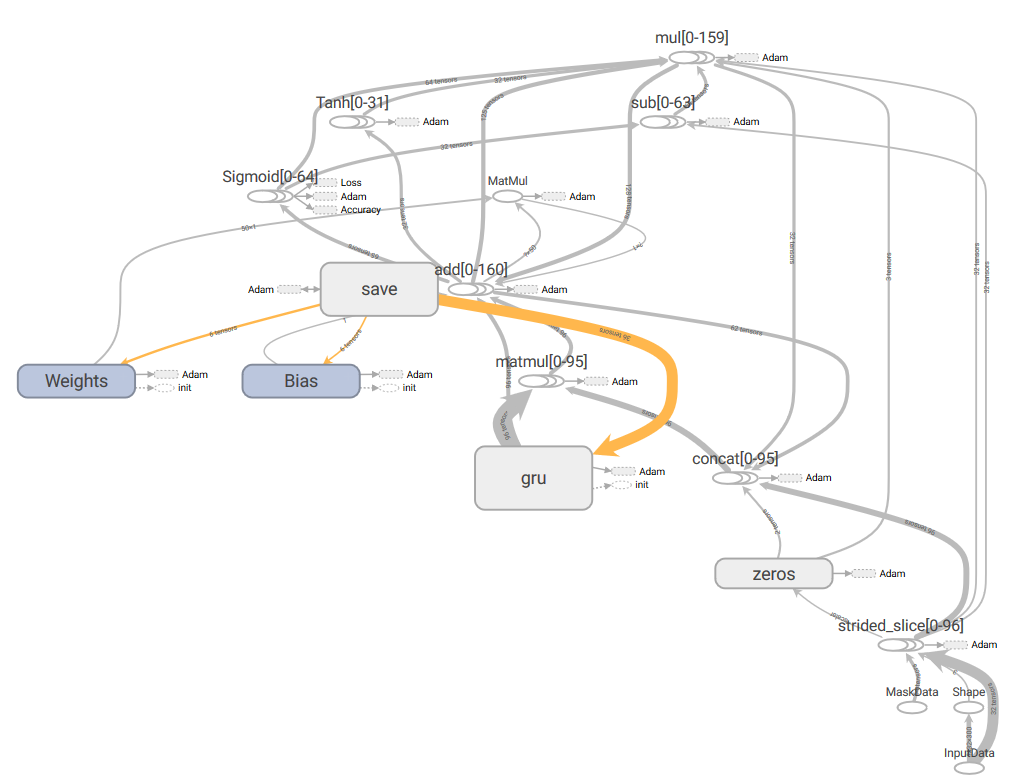)

The interesting thing is that due to the impossibility for the Tensorflow version to generate on-the-fly graph parts (the actions are kind of compiled and TF uses lazy evaluation), the LSTM cell is unique and will be used for the whole computation.

The same principle is illustrated in the figure below for RNN (Source: [colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)).

![]( 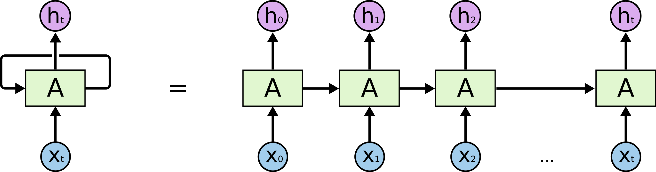)

Lastly, the GRU is a simplification of the LSTM model as there is no memory cell from which the result is forwarded. However, and surprisingly, the results are generally not far from LSTM results. This can be explained due to LSTM ability to memorize informations that last longuer and are a bit more latent and hidden from the input data, but we generally don't have enough training data to tune the LSTM parameters optimally and therefore LSTM can perform worse than GRU because the memory goes completely wrong in finding factors of interest in the data.